In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

In [15]:
#Get IGP data
data_path='/geos/d21/s1878599/IGP/outputs/autumn/base/wrfout*.nc'
shp_path =  '/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp'
IGP =igp.get_IGP(data_path, shp_path)

In [16]:
#Get aerosols for each IGP administration
aer_IGP = {}
for adm, val in IGP.items():
    aer_IGP.update({adm : aer.get_aerosols(val)}) 

In [17]:
# Get time average of values
t_aer_IGP = {}
for adm, val in aer_IGP.items():
    t_aer_IGP.update({adm : st.time_mean(val, "time")})

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
    
def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'gray'}
        gl.ylabel_style = {'size': 10, 'color': 'grey'} 

        
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.75)
    

def subIGP(dims,data, vmax=None, title=None, cmap="OrRd", levs=10, figsize=[10, 15]):

    fig, axes =plt.subplots(dims[0], dims[1], figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    u_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/U_IGP.shp"
    m_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/M_IGP.shp"
    l_shp= "/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/L_IGP.shp"
    shp_path=(u_shp,m_shp,l_shp)
    
    set_formatter(axes)
    set_admin(axes, shp_path)
    
    
     #setting levels for bar plot.
    v=list(data.values())
    
    if vmax is not None:  # set vmax in the bar to a fixed costumed value (useful to compare consitently different plots).
        vmax=vmax  
    else: 
        import math                # Get the max value in the array to plot, and round to the next hundreds.
        vmax =np.array([np.nanmax(v[0][2]),np.nanmax(v[1][2]),np.nanmax(v[2][2])]).max()       
        #vmax = int(math.ceil(max_val / 100.0)) * 100
    
    vmin=0
    levels = np.linspace(vmin, vmax,levs)  # number of levels for which divide the bar. Customised. 
    print("Max value is ", vmax)                                            
    cs_u=axes[0].contourf(v[0][0], v[0][1],v[0][2],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax) #U IGP values.
    cs_m=axes[1].contourf(v[1][0], v[1][1],v[1][2],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax) #M IGP values.
    cs_l=axes[2].contourf(v[2][0], v[2][1],v[2][2],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax)
    
    k=list(data.keys())
    axes[0].set_title(k[0])
    axes[1].set_title(k[1])
    axes[2].set_title(k[2])

    #set colorbar
    cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax.set_ylabel('Concetration [ug/m3]', fontsize=15)
    cax.yaxis.set_label_position('right')
    plt.colorbar(cs_u, cax=cax, **kw)
    
    #fig.colorbar(cs_l, cax=cax)
    #fig.colorbar.set_clim(vmin, vmax)
    if title is not None:
        fig.suptitle(title, fontsize=20)

In [19]:
#DEFINE PLOT DATA

# shapefiles, latitutes and longitudes for diffrent part of IGP

u_long = t_aer_IGP['U_IGP'].mean(dim='time').lon.values
u_lat = t_aer_IGP['U_IGP'].mean(dim='time').lat.values

m_long = t_aer_IGP['M_IGP'].mean(dim='time').lon.values
m_lat =  t_aer_IGP['M_IGP'].mean(dim='time').lat.values

l_long = t_aer_IGP['L_IGP'].mean(dim='time').lon.values
l_lat =  t_aer_IGP['L_IGP'].mean(dim='time').lat.values

In [20]:
# values pm25 
u_pm25 = t_aer_IGP['U_IGP'].PM2_5_DRY[0, :, :]
m_pm25 = t_aer_IGP['M_IGP'].mean(dim='time').PM2_5_DRY[0, :, :]
l_pm25 = t_aer_IGP['L_IGP'].mean(dim='time').PM2_5_DRY[0, :, :]

# plot dictionary
plot_data_pm25={}
plot_data_pm25.update({"UPPER IGP": (u_long, u_lat,u_pm25)})
plot_data_pm25.update({"MIDDLE IGP":(m_long, m_lat,m_pm25)})
plot_data_pm25.update({"LOWER IGP":(l_long, l_lat, l_pm25)})

In [21]:
# values pm25 POA
u_pm25_POA = t_aer_IGP['U_IGP'].pm25_POA[0, :, :]
m_pm25_POA = t_aer_IGP['M_IGP'].mean(dim='time').pm25_POA[0, :, :]
l_pm25_POA = t_aer_IGP['L_IGP'].mean(dim='time').pm25_POA[0, :, :]

# plot dictionary
plot_data_poa={}
plot_data_poa.update({"UPPER IGP": (u_long, u_lat,u_pm25_POA)})
plot_data_poa.update({"MIDDLE IGP":(m_long, m_lat,m_pm25_POA)})
plot_data_poa.update({"LOWER IGP":(l_long, l_lat, l_pm25_POA)})

In [22]:
# values pm25 SOA
u_pm25_SOA = t_aer_IGP['U_IGP'].pm25_SOA[0, :, :]
m_pm25_SOA = t_aer_IGP['M_IGP'].mean(dim='time').pm25_SOA[0, :, :]
l_pm25_SOA = t_aer_IGP['L_IGP'].mean(dim='time').pm25_SOA[0, :, :]

# plot dictionary
plot_data_soa={}
plot_data_soa.update({"UPPER IGP": (u_long, u_lat,u_pm25_SOA)})
plot_data_soa.update({"MIDDLE IGP":(m_long, m_lat,m_pm25_SOA)})
plot_data_soa.update({"LOWER IGP":(l_long, l_lat, l_pm25_SOA)})

In [23]:
np.nanmax(u_pm25_SOA.values)

22.538422

Max value is  389.9845


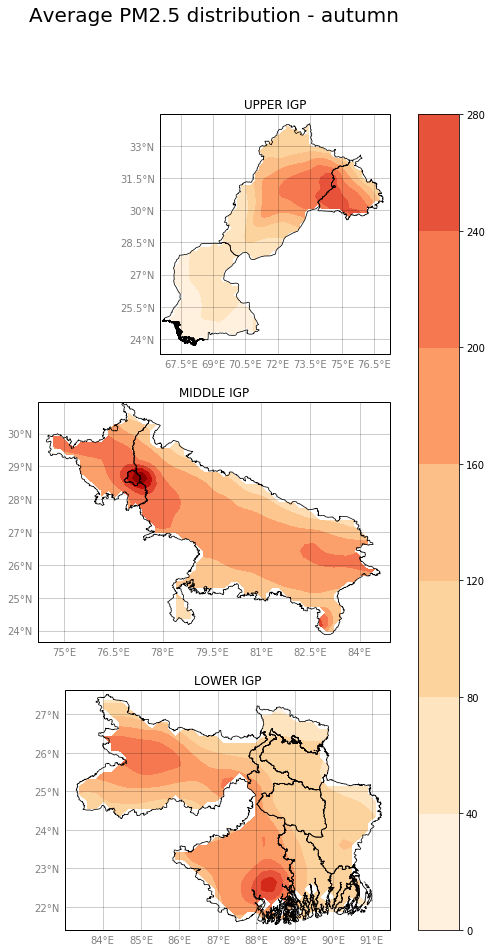

In [24]:
subIGP([3,1], plot_data_pm25, title='Average PM2.5 distribution - autumn')

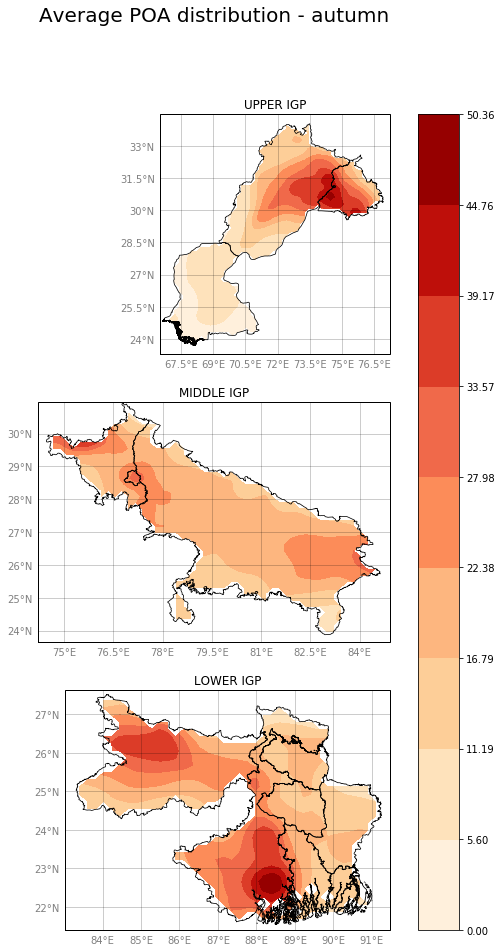

In [11]:
subIGP([3,1], plot_data_poa, title='Average POA distribution - autumn')

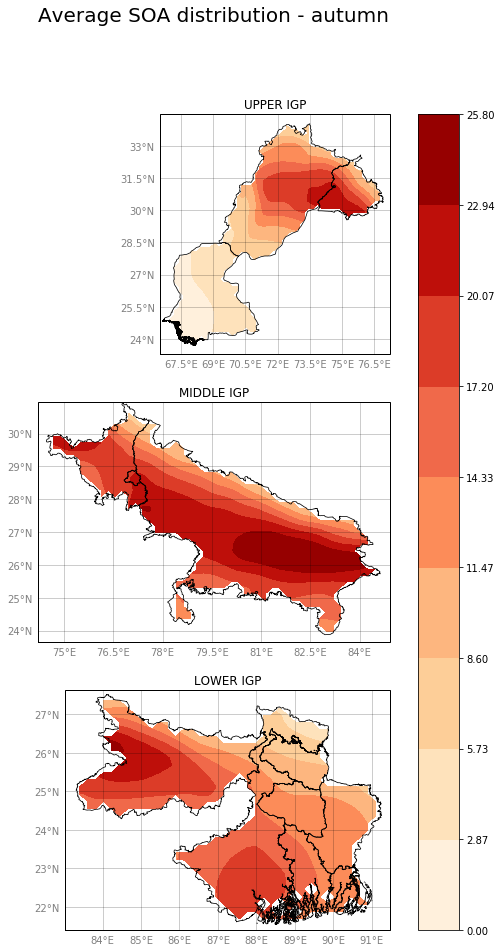

In [12]:
subIGP([3,1], plot_data_soa, title='Average SOA distribution - autumn')